In [1]:
import sys
from pathlib import Path

def get_project_root():
    for path in (Path.cwd(), *Path.cwd().parents):
        if (path / 'src').exists():
            return path
    raise ModuleNotFoundError("Could not find 'src' directory from current working directory.")

project_root = get_project_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.plot_data_utils import PlotDataUtils
from src.classical_MILP_solver import ClassicalMILPSolver

In this tutorial we present the main idea of the algorithm that we propose. We model the problem mathematically as follows:

### Optimization model (step by step)

Let $t \in \{1,\dots,24\}$ index hours and $s \in \{1,\dots,13\}$ index equiprobable wind scenarios with probability $\pi_s = 1/13$. Prices $p_t$ are deterministic; wind energy in each scenario is $W_{t,s}$.

### Parameters

- Battery energy capacity: $E^{\max} = 16$ MWh
- Charging power limit: $P^{\max}_{\mathrm{ch}} = 5$ MW (so $\le 5$ MWh per hour)
- Discharging power limit: $P^{\max}_{\mathrm{dis}} = 4$ MW (so $\le 4$ MWh per hour)
- Charging efficiency: $\eta_{\mathrm{ch}} = 0.8$
- Discharging efficiency: $\eta_{\mathrm{dis}} = 1.0$
- Initial and terminal SOC: $E_0 = 0$, $E_{24} = 0$
- Cycle budget (equivalent full cycles, EFC proxy): $\sum_{t=1}^{24} d_t \le N^{\mathrm{cyc}} E^{\max}$ with $N^{\mathrm{cyc}} = 2$, i.e. $\sum_t d_t \le 32$ MWh
- We optionally include a soft continuity condition using a switching/start penalty weight: $\lambda \ge 0$

### Decision variables (day-ahead, scenario-independent)

Continuous variables:
- $c_t \ge 0$: charging energy bought from the grid (MWh) in hour $t$
- $d_t \ge 0$: discharging energy sold to the grid (MWh) in hour $t$
- $E_t \in [0, E^{\max}]$: state of charge at end of hour $t$ (MWh)

Binary variables (3-state operation):
- $y^{\mathrm{ch}}_t \in \{0,1\}$: 1 if the battery is in charging mode at hour $t$
- $y^{\mathrm{dis}}_t \in \{0,1\}$: 1 if the battery is in discharging mode at hour $t$
- $y^{\mathrm{id}}_t \in \{0,1\}$: 1 if the battery is idle at hour $t$

Binary variables (to count contiguous blocks / starts):
- $u^{\mathrm{ch}}_t \in \{0,1\}$: 1 if a charging block starts at hour $t$
- $u^{\mathrm{dis}}_t \in \{0,1\}$: 1 if a discharging block starts at hour $t$

### Objective (expected revenue)

$$\max \; \sum_{s=1}^{13} \pi_s \sum_{t=1}^{24} p_t w_{t,s} + \sum_{t=1}^{24} p_t \bigl(d_t - c_t\bigr) - \lambda \sum_{t=1}^{24}\bigl(u^{\mathrm{ch}}_t + u^{\mathrm{dis}}_t\bigr)$$

Under the "no netting" rule, the wind term $\sum_s \pi_s \sum_t p_t w_{t,s}$ is constant w.r.t. the battery decisions, so the battery schedule depends only on prices. Setting $\lambda=0$ gives the pure profit-maximizing schedule; $\lambda>0$ softly prefers fewer on/off blocks.

### Constraints

1. **SOC dynamics and bounds**
   
   $$E_t = E_{t-1} + \eta_{\mathrm{ch}} c_t - \frac{1}{\eta_{\mathrm{dis}}} d_t \qquad \forall t=1,\dots,24$$
   
   $$0 \le E_t \le E^{\max} \qquad \forall t=1,\dots,24$$
   
   $$E_0 = 0,\qquad E_{24}=0$$

2. **3-state operation and power limits**
   
   $$y^{\mathrm{ch}}_t + y^{\mathrm{dis}}_t + y^{\mathrm{id}}_t = 1 \qquad \forall t$$
   
   $$0 \le c_t \le P^{\max}_{\mathrm{ch}}\, y^{\mathrm{ch}}_t \qquad \forall t$$
   
   $$0 \le d_t \le P^{\max}_{\mathrm{dis}}\, y^{\mathrm{dis}}_t \qquad \forall t$$

3. **“Continuous operation”: no immediate charge$\leftrightarrow$discharge reversals**  
   (must pass through idle between opposite modes)
   
   $$y^{\mathrm{ch}}_t + y^{\mathrm{dis}}_{t+1} \le 1 \qquad \forall t=1,\dots,23$$
   
   $$y^{\mathrm{dis}}_t + y^{\mathrm{ch}}_{t+1} \le 1 \qquad \forall t=1,\dots,23$$

4. **Count charging/discharging blocks (starts)**
   
   $$u^{\mathrm{ch}}_1 \ge y^{\mathrm{ch}}_1,\qquad u^{\mathrm{dis}}_1 \ge y^{\mathrm{dis}}_1$$
   
   $$u^{\mathrm{ch}}_t \ge y^{\mathrm{ch}}_t - y^{\mathrm{ch}}_{t-1} \qquad \forall t=2,\dots,24$$
   
   $$u^{\mathrm{dis}}_t \ge y^{\mathrm{dis}}_t - y^{\mathrm{dis}}_{t-1} \qquad \forall t=2,\dots,24$$

5. **Limit the number of charging/discharging blocks**  
   (to avoid frequent plugging/unplugging)
   
   $$\sum_{t=1}^{24} u^{\mathrm{ch}}_t \le 2,\qquad \sum_{t=1}^{24} u^{\mathrm{dis}}_t \le 2$$

6. **Cycle budget (EFC proxy)**
   
   $$\sum_{t=1}^{24} d_t \le N^{\mathrm{cyc}} E^{\max} = 32$$



So we first load the data and compute the wind revenue. This will be the constant shift in the revenue:

In [2]:
# Initialise utilities for the input CSV data
data_utils = PlotDataUtils(Path('../data/input_data.csv'))
df = data_utils.load_data()

df = data_utils.compute_wind_stats(df)
wind_rev_by_s, wind_rev_exp, wind_rev_min, wind_rev_max, wind_rev_var = data_utils.wind_revenue(df)


Then we generate a QAOA initial guess with the following modifications of the problem ........

In [4]:
charge_pattern = [0]*8 + [1]*4 + [0]*12


This provides a sensible warm-start (MIP start) by setting initial values for the binary mode variables and associated charge/discharge levels. PuLP then builds the full MILP (constraints + objective) and dispatches it to CBC, which solves it using a branch-and-cut MILP algorithm (LP relaxations + branching + cuts) and returns the optimal schedule.

In [5]:
solver = ClassicalMILPSolver(charge_pattern=charge_pattern, lambda_switch=00.0)

schedule, status, battery_profit, total_revenue = solver.solve(df, wind_rev_exp)

In [6]:
print(f"Solver status: {status}")
print(f"Battery profit: EUR {battery_profit:,.2f}")
print(f"Total expected revenue (wind + battery): EUR {total_revenue:,.2f}")
print(schedule.head())

Solver status: Optimal
Battery profit: EUR 2,034.54
Total expected revenue (wind + battery): EUR 19,680.02
   hour  charge_MWh  discharge_MWh  soc_MWh  mode_charge  mode_discharge  \
0     1         0.0            0.0      0.0          0.0             0.0   
1     2         0.0            0.0      0.0          0.0             0.0   
2     3         0.0            0.0      0.0          0.0             0.0   
3     4         5.0            0.0      4.0          1.0             0.0   
4     5         5.0            0.0      8.0          1.0             0.0   

   price  mode_idle  start_charge_block  start_discharge_block  
0  88.96        1.0                 0.0                    0.0  
1  83.82        1.0                 0.0                    0.0  
2  83.00        1.0                 0.0                    0.0  
3  82.56        0.0                 1.0                    0.0  
4  82.82        0.0                 0.0                    0.0  


And we can finally use our defined functions to plot the charge-discharge schedule:

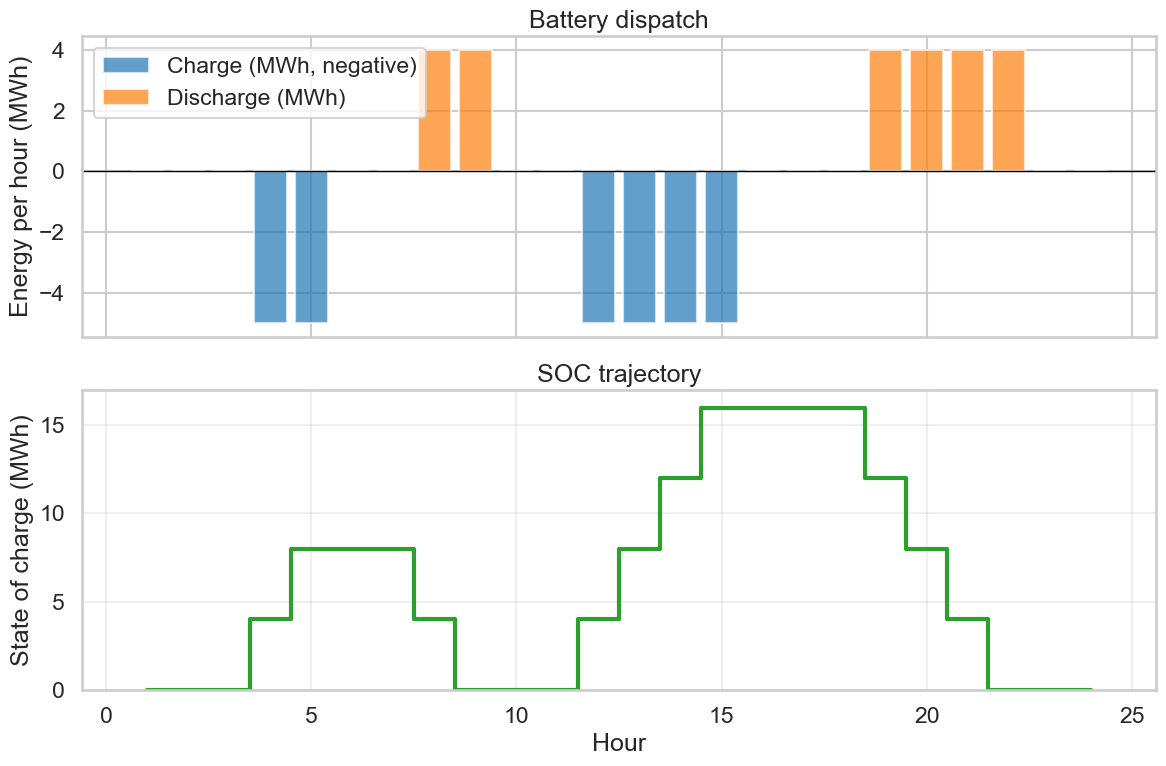

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Battery dispatch'}, ylabel='Energy per hour (MWh)'>,
  <Axes: title={'center': 'SOC trajectory'}, xlabel='Hour', ylabel='State of charge (MWh)'>))

In [7]:
solver.plot_battery_schedule(schedule)